<a href="https://colab.research.google.com/github/dlmf15/kmean_EFE_videos/blob/main/RFM_Kmeans_TFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
df = pd.read_csv('/content/efevideo_clean.csv')
df = df.loc[df['type_abono'] != 'Pruebas'] # delete 'Pruebas', it's free try.
df['date']=pd.to_datetime(df['date'])

df.entry.replace(0,1000, inplace=True) # set 0 to 1000, 0 means it's unlimited count, but it won't superior 1000
df.entry.replace(1.000, 1000, inplace=True)
df['entry']=df.entry.astype(int)
#df.rename(columns={'num':'ID'},inplace = True)
df = df.reset_index(drop = True)
df.index = df.index + 1

In [ ]:
df_M = df.groupby(['num','entry']).agg({'date': lambda x: x.max().month-x.min().month+1}).reset_index()
df_M['M'] = df_M['entry'] * df_M['date']
grouped = df_M.groupby('num')
df_M = pd.DataFrame(grouped['M'].agg(np.sum)).reset_index()
NOW = df['date'].max() + timedelta(days=1)
df_R = df.groupby('num').agg({'date': lambda x: (NOW-x.max()).days}).reset_index()
df_F = df.groupby('num').client.count().reset_index()
rfm = pd.merge(df_R, df_F,on='num')
rfm = pd.merge(rfm, df_M, on='num' )
rfm = rfm.rename(columns={'date':'Recency', 'client':'Frequency', 'M':'Monetary'})

In [ ]:
rfm.head()

,num,Recency,Frequency,Monetary
0,271,1,637,7000
1,323,1,2554,5600
2,332,91,1,100
3,375,1,158,350
4,459,1,1344,3500


In [ ]:
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Frequency': {0.2: 13.400000000000006,
  0.4: 61.80000000000001,
  0.6: 186.5999999999999,
  0.8: 683.4000000000001},
 'Monetary': {0.2: 420.0, 0.4: 1360.0000000000023, 0.6: 3000.0, 0.8: 7000.0},
 'Recency': {0.2: 1.0, 0.4: 2.0, 0.6: 16.0, 0.8: 43.60000000000002}}

In [ ]:
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1
    
def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5

In [ ]:
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))
rfm['RFM_Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,num,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,271,1,637,7000,5,4,4,544
1,323,1,2554,5600,5,5,4,554
2,332,91,1,100,1,1,1,111
3,375,1,158,350,5,3,1,531
4,459,1,1344,3500,5,5,4,554


In [ ]:
rfm['RFM_Score_sum'] = rfm[['R', 'F', 'M']].sum(axis = 1)
rfm.head()

,num,Recency,Frequency,Monetary,R,F,M,RFM_Score,RFM_Score_sum
0,271,1,637,7000,5,4,4,544,13
1,323,1,2554,5600,5,5,4,554,14
2,332,91,1,100,1,1,1,111,3
3,375,1,158,350,5,3,1,531,9
4,459,1,1344,3500,5,5,4,554,14


In [ ]:
rfm.tail(10)

,num,Recency,Frequency,Monetary,R,F,M,RFM_Score,RFM_Score_sum
203,932209,56,40,5000,1,2,4,124,7
204,932278,146,2,1000,1,1,2,112,4
205,932310,1,801,4000,5,5,4,554,14
206,932418,17,52,4000,2,2,4,224,8
207,932528,1,239,3000,5,4,3,543,12
208,932750,42,26,2000,2,2,3,223,7
209,932803,34,42,1000,2,2,2,222,6
210,932955,1,95,1200,5,3,2,532,10
211,933006,26,1389,4000,2,5,4,254,11
212,933025,3,1,50,3,1,1,311,5


In [ ]:
rfm.tail()

,num,Recency,Frequency,Monetary,R,F,M,RFM_Score,RFM_Score_sum
208,932750,42,26,2000,2,2,3,223,7
209,932803,34,42,1000,2,2,2,222,6
210,932955,1,95,1200,5,3,2,532,10
211,933006,26,1389,4000,2,5,4,254,11
212,933025,3,1,50,3,1,1,311,5


In [ ]:

# calculate average values for each RFM
rfm_agg = rfm.groupby('RFM_Score_sum').agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'Monetary' : ['mean', 'count']
})
rfm_agg.round(1)

Recency Frequency Monetary      
                 mean      mean     mean count
RFM_Score_sum                                 
3               110.6       3.1    136.7    12
4               101.7       9.2    755.0    12
5                84.6      28.9   1030.8    20
6                51.5      40.2   1385.8    19
7                30.9      56.6   2424.1    17
8                14.8      87.7   2491.2    20
9                11.4     148.4   3020.3    18
10               12.4     272.5   4191.1    19
11                5.0     685.6   2119.2    13
12                3.0     646.6   4269.2    13
13                1.0     798.5   4545.5    27
14                1.0    1797.0   6039.1    23

In [ ]:
def r_score_sum(x):
    if x > 10:
        return 'Primero'
    elif x > 5:
        return 'Segundo'
    else:
        return 'Tercero'

In [ ]:
rfm['RFM_Level'] = rfm['RFM_Score_sum'].apply(lambda x : r_score_sum(x))

In [ ]:
rfm.head()

,num,Recency,Frequency,Monetary,R,F,M,RFM_Score,RFM_Score_sum,RFM_Level
0,271,1,637,7000,5,4,4,544,13,Primero
1,323,1,2554,5600,5,5,4,554,14,Primero
2,332,91,1,100,1,1,1,111,3,Tercero
3,375,1,158,350,5,3,1,531,9,Segundo
4,459,1,1344,3500,5,5,4,554,14,Primero


In [ ]:
'''score_labels = ['C','Tercero', 'Segundo', 'Primero']
score_groups = pd.qcut(rfm.RFM_Score, q = 4, labels = score_labels)
rfm['RFM_Level'] = score_groups.values
rfm.head()'''

,num,Recency,Frequency,Monetary,R,F,M,RFM_Score,RFM_Score_sum,RFM_Level
0,271,1,637,7000,5,4,4,544,13,Primero
1,323,1,2554,5600,5,5,4,554,14,Primero
2,332,91,1,100,1,1,1,111,3,C
3,375,1,158,350,5,3,1,531,9,Segundo
4,459,1,1344,3500,5,5,4,554,14,Primero


In [ ]:
rfm= rfm.rename(columns={'Recency':'Recencia',
                         'Frequency':'Frecuencia',
                         'Monetary':'Valor Monetario'})

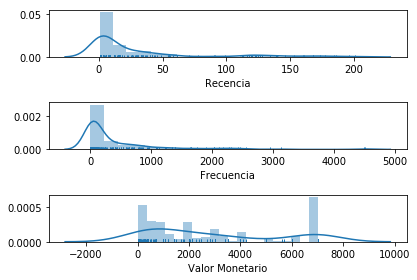

In [ ]:
# plot the distribution of RFM values
fig = plt.figure()
plt.subplot(3, 1, 1); sns.distplot(rfm['Recencia'],bins=20, rug=True)
plt.subplot(3, 1, 2); sns.distplot(rfm['Frecuencia'],bins=20,rug=True)
plt.subplot(3, 1, 3); sns.distplot(rfm['Valor Monetario'],bins=20,rug=True)

plt.tight_layout()
plt.show()
fig.savefig('RFM_original.png')

In [ ]:
# define function for the values below 0
def neg_to_zero(x):
    if x <= 0:
        return 1
    else:
        return x
# apply the function to Recency and MonetaryValue column 
rfm['Recencia'] = [neg_to_zero(x) for x in rfm['Recencia']]
rfm['Frecuencia'] = [neg_to_zero(x) for x in rfm['Frecuencia']]
rfm['Valor Mentario'] = [neg_to_zero(x) for x in rfm['Valor Monetario']]
# unskew the data
rfm_log = rfm[['Recencia', 'Frecuencia', 'Valor Monetario']].apply(np.log, axis = 1).round(3)

In [ ]:
def normal_R(x):
  nor_r = (max(rfm.Recencia)-x)/(max(rfm.Recencia)-min(rfm.Recencia))
  return nor_r
def normal_F(x):
  nor_f = (x-min(rfm.Frecuencia))/(max(rfm.Frecuencia)-min(rfm.Frecuencia))
  return nor_f
def normal_M(x):
  nor_m = (x-min(rfm['Valor Monetario']))/(max(rfm['Valor Monetario'])-min(rfm['Valor Monetario']))
  return nor_m


In [ ]:
rfm_normal = rfm[['Recencia']].apply(lambda x: normal_R(x))
rfm_normal['Frecuencia'] = rfm[['Frecuencia']].apply(lambda x: normal_F(x))
rfm_normal['Valor Monetario'] = rfm[['Valor Monetario']].apply(lambda x: normal_M(x))

In [ ]:
rfm_normal

In [ ]:
rfm_normal.describe()

In [ ]:
rfm_log.head()

,Recencia,Frecuencia,Valor Monetario
0,0.000,6.457,8.854
1,0.000,7.845,8.631
2,4.511,0.000,4.605
3,0.000,5.063,5.858
4,0.000,7.203,8.161


In [ ]:
# scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
# transform into a dataframe
rfm_scaled = pd.DataFrame(rfm_scaled, index = rfm.num, columns = rfm_log.columns)

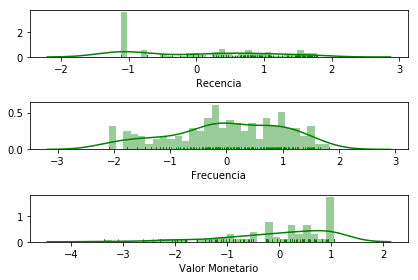

In [ ]:

fig = plt.figure()
plt.subplot(3, 1, 1); sns.distplot(rfm_scaled['Recencia'], bins=30, rug=True, color="g")
plt.subplot(3, 1, 2); sns.distplot(rfm_scaled['Frecuencia'], bins=30, rug=True,color="g")
plt.subplot(3, 1, 3); sns.distplot(rfm_scaled['Valor Monetario'], bins=30, rug=True, color="g")

plt.tight_layout()
plt.show()
fig.savefig('RFM_standard.png')

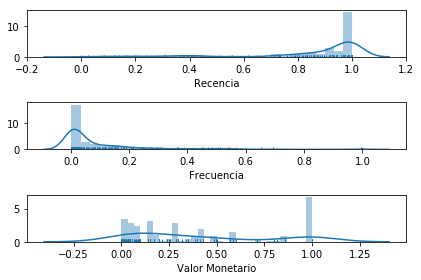

In [ ]:
fig = plt.figure()
plt.subplot(3, 1, 1); sns.distplot(rfm_normal['Recencia'], bins=30, rug=True)
plt.subplot(3, 1, 2); sns.distplot(rfm_normal['Frecuencia'], bins=30, rug=True)
plt.subplot(3, 1, 3); sns.distplot(rfm_normal['Valor Monetario'], bins=30, rug=True)

plt.tight_layout()
plt.show()
fig.savefig('RFM_normalize.png')

In [ ]:
# initiate an empty dictionary
wcss = {}

# Elbow method with for loop
for i in range(1, 11):
    kmeans = KMeans(n_clusters= i, init= 'k-means++', max_iter= 500)
    kmeans.fit(rfm_scaled)
    wcss[i] = kmeans.inertia_

In [ ]:
'''# initiate an empty dictionary
wcss = {}

# Elbow method with for loop
for i in range(1, 11):
    kmeans = KMeans(n_clusters= i, init= 'k-means++', max_iter= 500)
    kmeans.fit(rfm_normal)
    wcss[i] = kmeans.inertia_'''

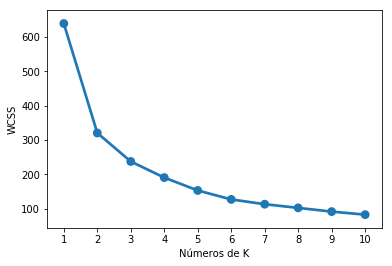

In [ ]:
fig = plt.figure()
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.xlabel('Números de K')
plt.ylabel('WCSS')
plt.show()
fig.savefig('elbo.png')

In [ ]:
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.xlabel('K Numbers')
plt.ylabel('WCSS')
plt.show()

In [ ]:
# choose n_clusters = 3
clus = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 300)
clus.fit(rfm_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
clus = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 500)
clus.fit(rfm_normal)

In [ ]:
pd.Series(clus.labels_).value_counts()

0    92
1    71
2    50
dtype: int64

In [ ]:
pd.Series(rfm.RFM_Level).value_counts()

Segundo    93
Primero    76
Tercero    44
Name: RFM_Level, dtype: int64

In [ ]:
pd.DataFrame(clus.cluster_centers_)

,0,1,2
0,-0.973728,0.845756,0.391769
1,0.601368,-0.358434,0.424771
2,0.937718,-1.047215,-1.324029


In [ ]:
rfm['K_Cluster'] = clus.labels_
rfm.head()

,num,Recencia,Frecuencia,Valor Monetario,R,F,M,RFM_Score,RFM_Score_sum,RFM_Level,K_Cluster
0,271,1,637,7000,5,4,4,544,13,Primero,0
1,323,1,2554,5600,5,5,4,554,14,Primero,0
2,332,91,1,100,1,1,1,111,3,Tercero,2
3,375,1,158,350,5,3,1,531,9,Segundo,0
4,459,1,1344,3500,5,5,4,554,14,Primero,0


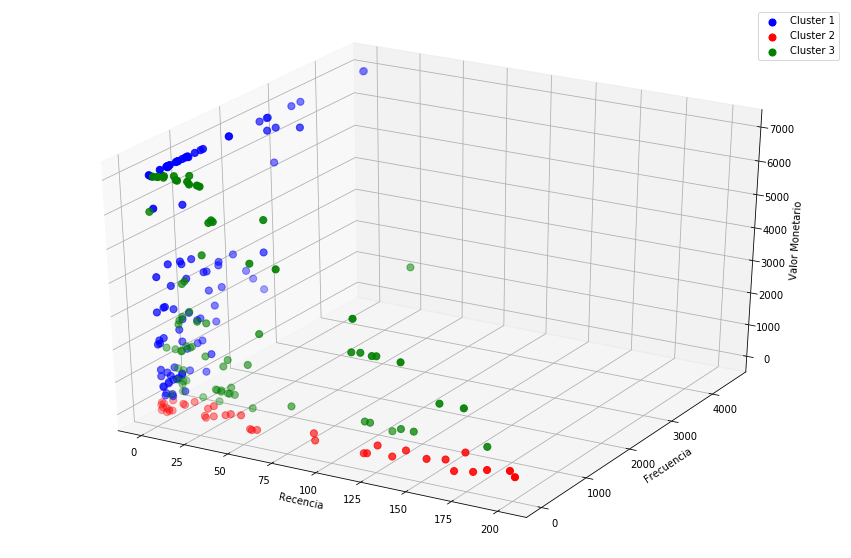

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,10))
dx = fig.add_subplot(111, projection='3d')
colors = ['b', 'r', 'g']

for i in range(0,3):
    dx.scatter(rfm[rfm.K_Cluster == i]['Recencia'], 
               rfm[rfm.K_Cluster == i]['Frecuencia'], 
               rfm[rfm.K_Cluster == i]['Valor Monetario'], 
               c = colors[i], 
               label = 'Cluster ' + str(i+1), 
               s=50)
#dx.scatter(kmeans4.cluster_centers_[:,0], kmeans4.cluster_centers_[:,1],kmeans4.cluster_centers_[:,2],s=50,marker='s', c='black', alpha=1, label='Centroids')

#dx.set_title('Clusters of clients')
dx.set_xlabel('Recencia')
dx.set_ylabel('Frecuencia')
dx.set_zlabel('Valor Monetario')
dx.legend()

fig.savefig('/content/3d_plot_cluster3.png')

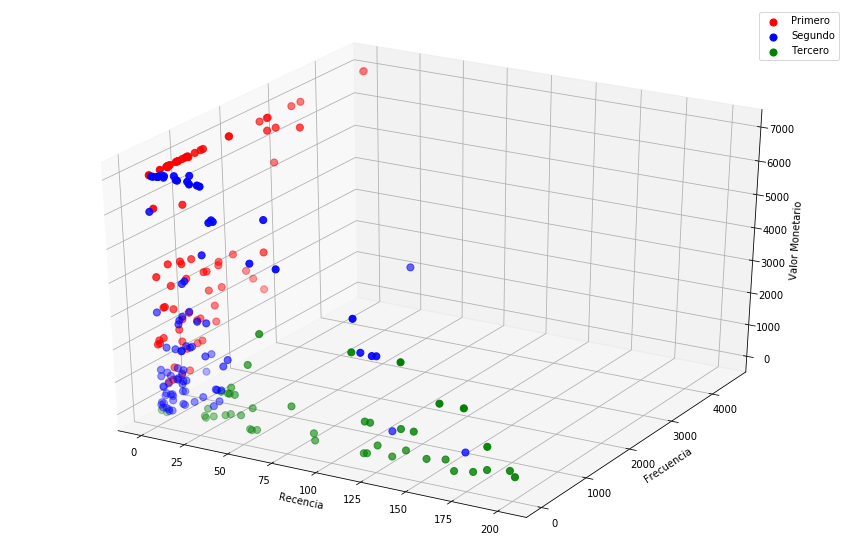

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,10))
dx = fig.add_subplot(111, projection='3d')
colors = ['r', 'b', 'g']
list_level =['Primero','Segundo','Tercero']
for i in range(0,3):
    dx.scatter(rfm[rfm.RFM_Level == list_level[i]]['Recencia'], 
               rfm[rfm.RFM_Level == list_level[i]]['Frecuencia'], 
               rfm[rfm.RFM_Level == list_level[i]]['Valor Monetario'], 
               c = colors[i], 
               label = list_level[i], 
               s=50)
#dx.scatter(kmeans4.cluster_centers_[:,0], kmeans4.cluster_centers_[:,1],kmeans4.cluster_centers_[:,2],s=50,marker='s', c='black', alpha=1, label='Centroids')

#dx.set_title('Clusters of clients')
dx.set_xlabel('Recencia')
dx.set_ylabel('Frecuencia')
dx.set_zlabel('Valor Monetario')
dx.legend()

fig.savefig('/content/3d_plot_cluster_level.png')

In [ ]:
# Assign the clusters to datamart
rfm['K_Cluster'] = clus.labels_+1
rfm.head()

,num,Recencia,Frecuencia,Valor Monetario,R,F,M,RFM_Score,RFM_Score_sum,RFM_Level,K_Cluster
0,271,1,637,7000,5,4,4,544,13,Primero,1
1,323,1,2554,5600,5,5,4,554,14,Primero,1
2,332,91,1,100,1,1,1,111,3,Tercero,3
3,375,1,158,350,5,3,1,531,9,Segundo,1
4,459,1,1344,3500,5,5,4,554,14,Primero,1


In [ ]:
# assign cluster column 
rfm_scaled['K_Cluster'] = clus.labels_+1
rfm_scaled['RFM_Level'] = rfm.RFM_Level
#rfm_scaled.reset_index(inplace = True)

In [ ]:
rfm_normal['K_Cluster'] = clus.labels_
rfm_normal['RFM_Level'] = rfm.RFM_Level
rfm_normal.reset_index(inplace = True)

In [ ]:
rfm_normal.head()
rfm_normal['num'] =rfm.num
rfm_normal.head()

,index,Recencia,Frecuencia,Valor Monetario,K_Cluster,RFM_Level,num
0,0,1.00,0.140989,1.000000,0,Primero,271
1,1,1.00,0.565950,0.799714,0,Primero,323
2,2,0.55,0.000000,0.012876,1,Tercero,332
3,3,1.00,0.034804,0.048641,2,Segundo,375
4,4,1.00,0.297717,0.499285,2,Primero,459


In [ ]:
rfm_normal.drop(['index'], axis=1, inplace=True)
rfm_normal.head()

,Recencia,Frecuencia,Valor Monetario,K_Cluster,RFM_Level,num
0,1.00,0.140989,1.000000,0,Primero,271
1,1.00,0.565950,0.799714,0,Primero,323
2,0.55,0.000000,0.012876,1,Tercero,332
3,1.00,0.034804,0.048641,2,Segundo,375
4,1.00,0.297717,0.499285,2,Primero,459


In [ ]:
cols = rfm_normal.columns.tolist()
cols = cols[-1:] + cols[:-1]
rfm_normal = rfm_normal[cols]
rfm_normal.head()

,num,Recencia,Frecuencia,Valor Monetario,K_Cluster,RFM_Level
0,271,1.00,0.140989,1.000000,0,Primero
1,323,1.00,0.565950,0.799714,0,Primero
2,332,0.55,0.000000,0.012876,1,Tercero
3,375,1.00,0.034804,0.048641,2,Segundo
4,459,1.00,0.297717,0.499285,2,Primero


In [ ]:
rfm_scaled.head()

,num,Recencia,Frecuencia,Valor Monetario,K_Cluster,RFM_Level
0,271,-1.113818,0.914865,1.046495,1,Primero
1,323,-1.113818,1.561949,0.896376,1,Primero
2,332,1.349287,-2.095379,-1.813848,3,Tercero
3,375,-1.113818,0.264985,-0.970353,1,Segundo
4,459,-1.113818,1.262649,0.579981,1,Primero


In [ ]:
rfm_scaled['K_Cluster'] = rfm_scaled['K_Cluster'].apply(lambda x: 'Clueter '+ str(x))

In [ ]:
rfm_scaled

In [ ]:

# melt the dataframe
rfm_melted = pd.melt(frame= rfm_scaled, id_vars= ['num', 'RFM_Level', 'K_Cluster'], 
                     var_name = 'Metrics', value_name = 'Value')
rfm_melted.head()

,num,RFM_Level,K_Cluster,Metrics,Value
0,271,Primero,Clueter 1,Recencia,-1.113818
1,323,Primero,Clueter 1,Recencia,-1.113818
2,332,Tercero,Clueter 3,Recencia,1.349287
3,375,Segundo,Clueter 1,Recencia,-1.113818
4,459,Primero,Clueter 1,Recencia,-1.113818


In [ ]:
rfm_melted= rfm_melted.rename(columns={'RFM_Level':'RFM_Nivel',
                         'Metrics':'Variables',
                         'Value':'Valor'})

In [ ]:
rfm_melted_normal = pd.melt(frame= rfm_normal, id_vars= ['num', 'RFM_Level', 'K_Cluster'], 
                     var_name = 'Metrics', value_name = 'Value')
rfm_melted_normal.head()

In [ ]:
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'RFM_Level', data = rfm_melted_normal)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')

NameError: ignored

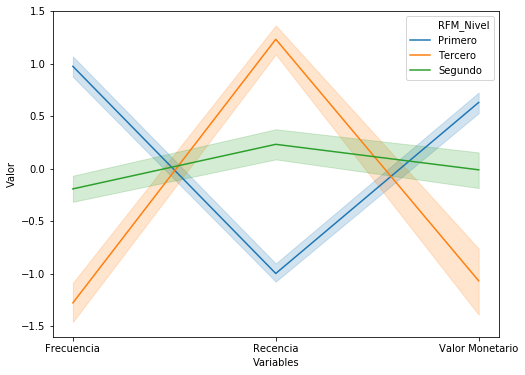

In [ ]:
fig = plt.figure(figsize=(8,6))
# a snake plot with RFM
sns.lineplot(x = 'Variables', y = 'Valor', hue = 'RFM_Nivel', data = rfm_melted)
#plt.title('Snake Plot de RFM')
plt.legend(loc = 'upper right')
fig.savefig('rfm_nivel_sanke.png')

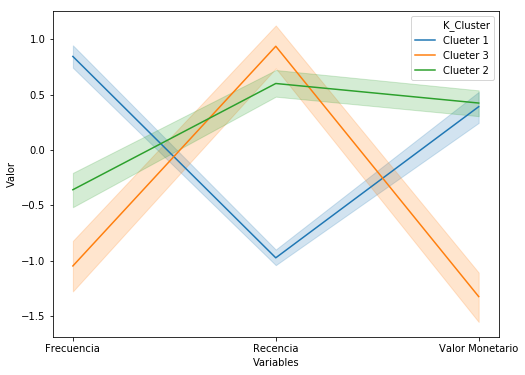

In [ ]:
fig = plt.figure(figsize=(8,6))
# a snake plot with K-Means
sns.lineplot(x = 'Variables', y = 'Valor', hue = 'K_Cluster', data = rfm_melted)
#plt.title('Snake Plot of K_cluster')
plt.legend(loc = 'upper right')
fig.savefig('k_cluster_snake.png')

In [ ]:
rfm_melted.K_Cluster=rfm_melted.K_Cluster.astype(object)

In [ ]:
rfm_melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639 entries, 0 to 638
Data columns (total 5 columns):
num          639 non-null int64
RFM_Level    639 non-null object
K_Cluster    639 non-null object
Metrics      639 non-null object
Value        639 non-null float64
dtypes: float64(1), int64(1), object(3)
memory usage: 25.0+ KB


In [ ]:
# the mean value for each cluster
cluster_avg = rfm.groupby('RFM_Level').mean().iloc[:, 1:4]
cluster_avg.head()

,Recencia,Frecuencia,Valor Monetario
RFM_Level,,,
Primero,2.039474,1055.407895,4535.250000
Segundo,24.075269,121.838710,2702.795699
Tercero,96.363636,16.477273,711.704545


In [ ]:
# the mean value in total 
total_avg = rfm.iloc[:, 1:4].mean()
total_avg

Recencia             31.145540
Frecuencia          433.178404
Valor Monetario    2945.323944
dtype: float64

In [ ]:

# the proportional mean value
prop_rfm = cluster_avg/total_avg - 1
prop_rfm

,Recencia,Frecuencia,Valor Monetario
RFM_Level,,,
Primero,-0.934518,1.436428,0.539814
Segundo,-0.227007,-0.718733,-0.082343
Tercero,2.093979,-0.961962,-0.758361


In [ ]:
prop_rfm.index.rename('RFM_Nivel', inplace=True)

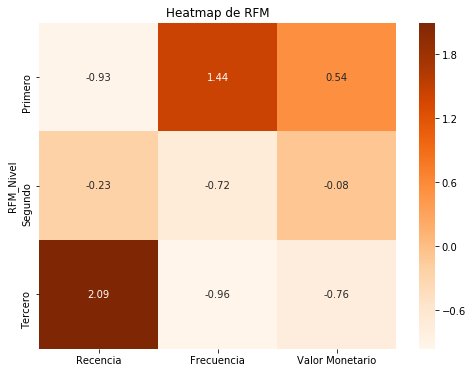

In [ ]:
fig = plt.figure(figsize=(8,6))
# heatmap
sns.heatmap(prop_rfm, cmap= 'Oranges', fmt= '.2f', annot = True)
plt.title('Heatmap de RFM')
plt.plot()
fig.savefig('heatmap_rfm.png')

In [ ]:
# the mean value for each cluster
cluster_avg_K = rfm.groupby('K_Cluster').mean().iloc[:, 1:4]

# the proportional mean value
prop_rfm_K = cluster_avg_K/total_avg - 1
prop_rfm_K

,Recencia,Frecuencia,Valor Monetario
K_Cluster,,,
1,-0.940322,1.069461,0.303241
2,0.201538,-0.730976,0.219790
3,1.444010,-0.929821,-0.870065


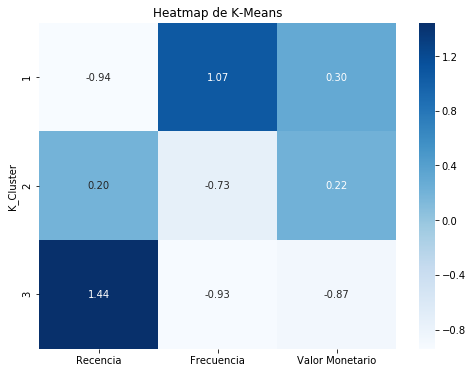

In [ ]:
fig = plt.figure(figsize=(8,6))
# heatmap
sns.heatmap(prop_rfm_K, cmap= 'Blues', fmt= '.2f', annot = True)
plt.title('Heatmap de K-Means')
plt.plot()
fig.savefig('heatmap_kmeans.png')

In [ ]:
import plotly
plotly.tools.set_credentials_file(username='jjone', api_key='')

import plotly.plotly as py
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, iplot 
init_notebook_mode(connected = True)

AttributeError: ignored

In [ ]:
sub = []
myColors = ['#db437b', '#d3d64d', '#568ce2', '#b467bc']
for i in range(3):
    df = rfm_scaled[rfm_scaled.K_Cluster == i]
    x = df.Recency
    y = df.Frequency
    z = df.Monetary
    color = myColors[i]
    
    trace = go.Scatter3d(x = x, y = y, z = z, name = str(i),
                         mode = 'markers', marker = dict(size = 5, color = color, opacity = .7))
    sub.append(trace)

In [ ]:
data = [sub[0], sub[1], sub[2]]
layout = go.Layout(margin = dict(l = 0, r = 0, b = 0, t = 0),
                  scene = dict(xaxis = dict(title = 'Recency'), yaxis = dict(title = 'Frequency'), zaxis = dict(title = 'Monetary')))
fig_1 = go.Figure(data = data, layout = layout)

In [ ]:
fig_1.show()

In [ ]:
!pip install plotly --upgrade

In [ ]:
sub_2 = []
#level = rfm_scaled.RFM_Level.tolist()
for i in range(4):
    df = rfm_scaled[rfm_scaled.RFM_Level == level[i]]
    x = df.Recency
    y = df.Frequency
    z = df.Monetary
    color = myColors[i]
    
    trace = go.Scatter3d(x = x, y = y, z = z, name = level[i], 
                         mode = 'markers', marker = dict(size = 5, color = color, opacity = .7))
    sub_2.append(trace)

In [ ]:

data = [sub_2[0], sub_2[1], sub_2[2], sub_2[3]]
layout = go.Layout(margin = dict(l = 10, r = 0, b = 0, t = 0), 
                  scene = dict(xaxis = dict(title = 'Recency'), yaxis = dict(title = 'Frequency'), zaxis = dict(title = 'Monetary')))
fig_2 = go.Figure(data = data, layout = layout)

In [ ]:
data

In [ ]:
fig_2.show()

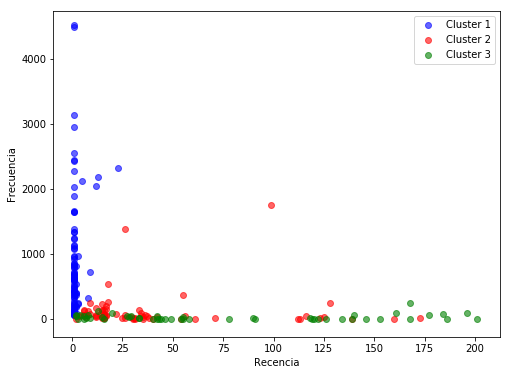

In [ ]:
fig = plt.figure(figsize=(8,6))
c1 = rfm[rfm.K_Cluster == 1]
c2 = rfm[rfm.K_Cluster == 2]
c3 = rfm[rfm.K_Cluster == 3]


plt.scatter(c1.Recencia, c1.Frecuencia, c = 'b', label = 'Cluster 1', alpha=0.6)
plt.scatter(c2.Recencia, c2.Frecuencia, c = 'r', label = 'Cluster 2', alpha=0.6)
plt.scatter(c3.Recencia, c3.Frecuencia, c = 'g', label = 'Cluster 3', alpha=0.6)

#plt.title('Clusters of clients')
plt.xlabel('Recencia')
plt.ylabel('Frecuencia')
plt.legend()
fig.savefig('FR.png')

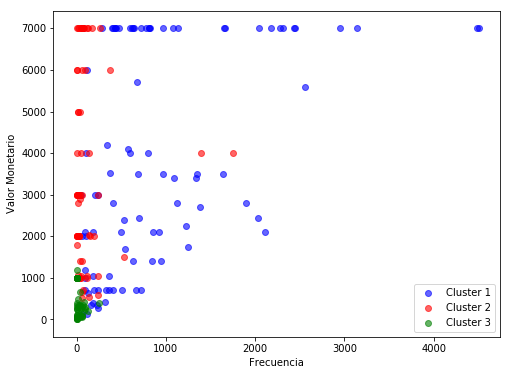

In [ ]:
fig = plt.figure(figsize=(8,6))
c1 = rfm[rfm.K_Cluster == 1]
c2 = rfm[rfm.K_Cluster == 2]
c3 = rfm[rfm.K_Cluster == 3]

plt.scatter(c1.Frecuencia, c1['Valor Monetario'], c = 'b', label = 'Cluster 1', alpha=0.6)
plt.scatter(c2.Frecuencia, c2['Valor Monetario'], c = 'r', label = 'Cluster 2', alpha=0.6)
plt.scatter(c3.Frecuencia, c3['Valor Monetario'], c = 'g', label = 'Cluster 3', alpha=0.6)


#plt.title('Clusters of clients')
plt.xlabel('Frecuencia')
plt.ylabel('Valor Monetario')
plt.legend()
fig.savefig('MF.png')

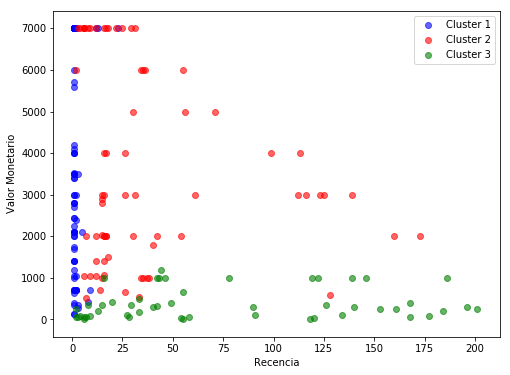

In [ ]:
fig = plt.figure(figsize=(8,6))
c1 = rfm[rfm.K_Cluster == 1]
c2 = rfm[rfm.K_Cluster == 2]
c3 = rfm[rfm.K_Cluster == 3]

plt.scatter(c1.Recencia, c1['Valor Monetario'], c = 'b', label = 'Cluster 1',alpha=0.6)
plt.scatter(c2.Recencia, c2['Valor Monetario'], c = 'r', label = 'Cluster 2', alpha=0.6)
plt.scatter(c3.Recencia, c3['Valor Monetario'], c = 'g', label = 'Cluster 3', alpha=0.6)

#plt.title('Clusters of clients')
plt.xlabel('Recencia')
plt.ylabel('Valor Monetario')
plt.legend()

fig.savefig('MR.png')